In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import the dataset after copying it to the local VM

In [2]:
! cp -r /content/gdrive/MyDrive/PGSS\ 2023/Week\ 2/IMDB\ Dataset.csv /content/

In [3]:
import pandas as pd
df = pd.read_csv("/content/IMDB Dataset.csv")

In [4]:
# Distribution of each type of review
df["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Learn to classify the text based on the sentiment response

## Cleanse the text data to remove things that wouldn't have any bearing on sentiment

In [6]:
# Convert all words to lowercase
df["review"] = df["review"].str.lower()

# Remove HTML tags using Beautiful soup
from bs4 import BeautifulSoup
df["review"] = df["review"].apply(lambda review: BeautifulSoup(review, "lxml").text)

# Remove urls
# From https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
import re
df["review"] = df["review"].apply(lambda review: re.sub(r'^https?:\/\/.*[\r\n]*', '', review, flags=re.MULTILINE))
df["review"] = df["review"].apply(lambda review: re.sub(r'^http?:\/\/.*[\r\n]*', '', review, flags=re.MULTILINE))

df.head()

<ipython-input-6-550c0fb5bf1e>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["review"] = df["review"].apply(lambda review: BeautifulSoup(review, "lxml").text)


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [7]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.7 MB/s eta 0:00:00


In [8]:
# Remove Contractions
import contractions
df["review"] = df["review"].apply(lambda review: contractions.fix(review))

## Create word cloud to get a birds-eye view of the data driven

In [9]:
#Create Word Cloud
from wordcloud import WordCloud, STOPWORDS

all_reviews = " "
positive_reviews = " "
negative_reviews =  ""

stopwords = set(STOPWORDS)


positive_df = df[df["sentiment"]  == "positive"]
negative_df = df[df["sentiment"]  == "negative"]

for review in positive_df.review:
    # Tokenize the review
    tokens = review.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    all_reviews += " ".join(tokens)+" "
    positive_reviews  += " ".join(tokens)+" "

for review in negative_df.review:
    # Tokenize the review
    tokens = review.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    all_reviews += " ".join(tokens)+" "
    negative_reviews  += " ".join(tokens)+" "

In [10]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_reviews)

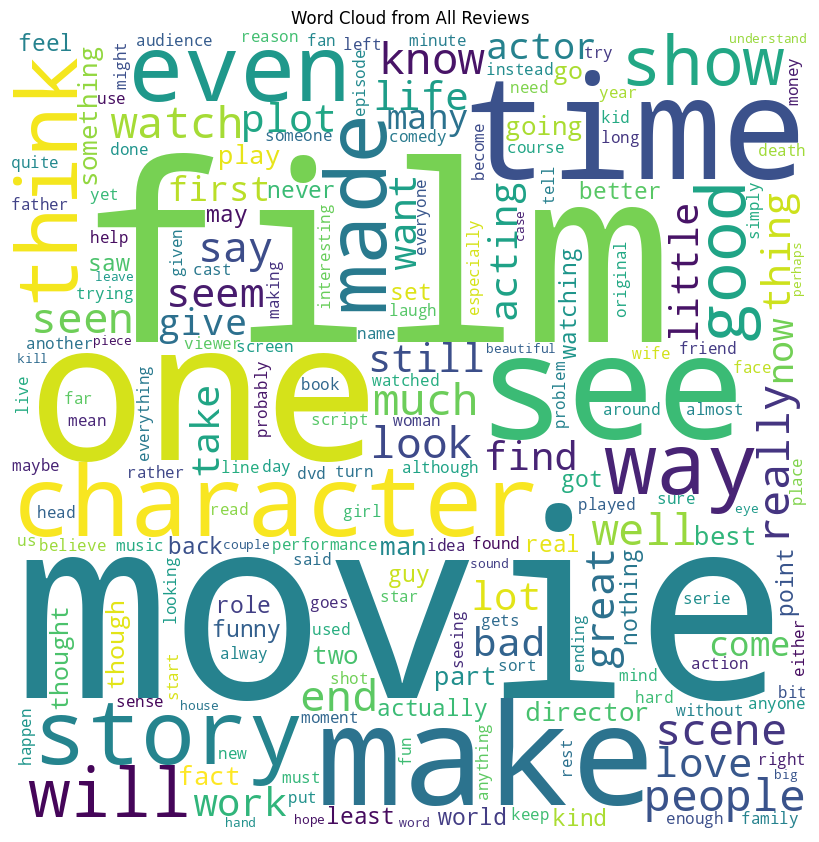

In [11]:
# plot the WordCloud image

import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word Cloud from All Reviews")
plt.show()

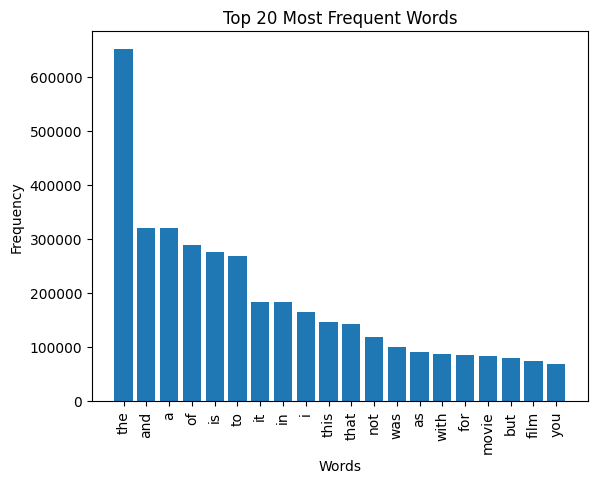

In [12]:
import re
from collections import Counter
import matplotlib.pyplot as plt


def create_barplot(string, k):
    # Step 1: Convert string to list of words
    words = string.split()

    # Step 2: Remove punctuation and special characters
    words = [re.sub(r'[^\w\s]', '', word) for word in words]

    # Step 3: Convert all words to lowercase
    words = [word.lower() for word in words]

    # Step 4: Count frequency of each word using dictionary
    word_counts = Counter(words)

    # Step 5: Sort dictionary by value in descending order and limit to top k
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:k])

    # Step 6: Create barplot using matplotlib
    plt.bar(sorted_word_counts.keys(), sorted_word_counts.values())
    plt.xticks(rotation=90)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {k} Most Frequent Words')
    plt.show()

k = 20

create_barplot(all_reviews, k)

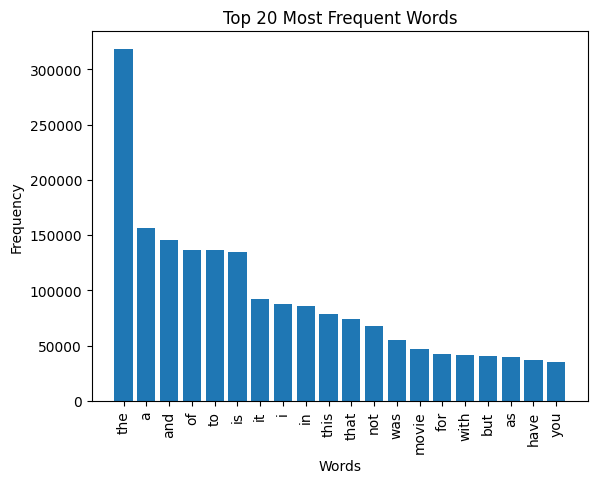

In [13]:
k = 20

create_barplot(negative_reviews, k)

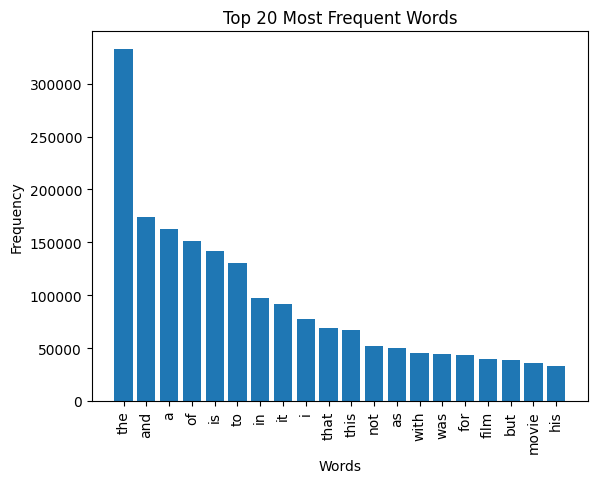

In [14]:
k = 20

create_barplot(positive_reviews, k)

In [15]:
# Define a function to count the number of words in a string
def count_words(text):
    return len(text.split())

# Apply the function to the reviews column using apply method
df['num_words'] = df['review'].apply(count_words)

# Create a new column in the dataframe with the number of words
df.head()

,review,sentiment,num_words
0,one of the other reviewers has mentioned that ...,positive,308
1,a wonderful little production. the filming tec...,positive,156
2,i thought this was a wonderful way to spend ti...,positive,164
3,basically there is a family where a little boy...,negative,135
4,"petter mattei's ""love in the time of money"" is...",positive,222


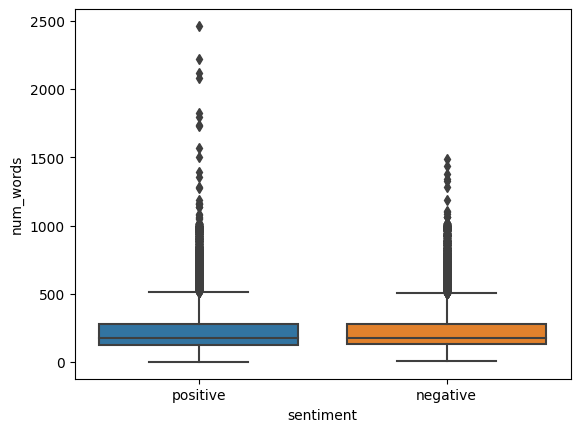

In [16]:
import seaborn as sns

# Create a grouped boxplot using seaborn's boxplot function
sns.boxplot(data=df, x='sentiment', y='num_words')

# Display the plot
plt.show()

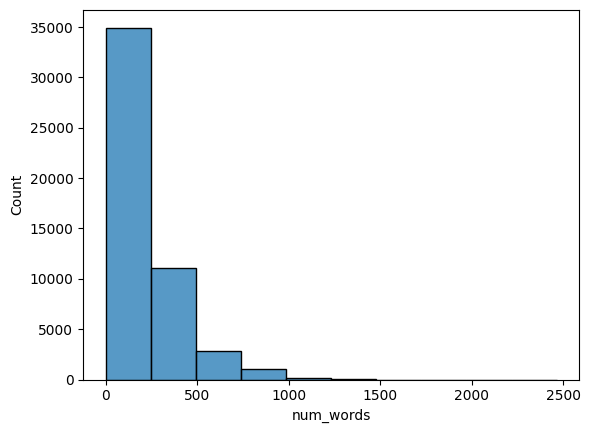

In [17]:
import seaborn as sns

# Create a histogram using seaborn's histplot function
sns.histplot(data=df, x='num_words', bins=10)

# Display the plots
plt.show()

<Axes: xlabel='num_words', ylabel='Density'>

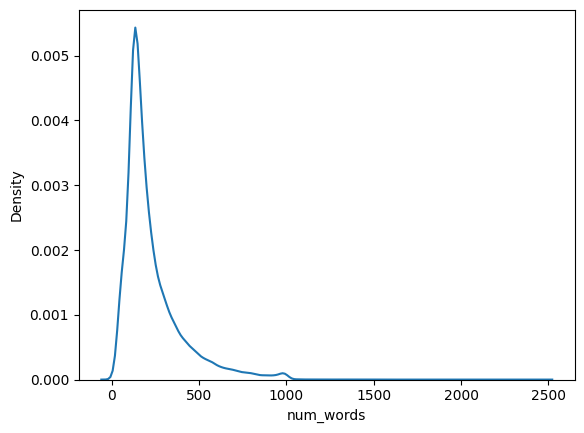

In [18]:
# Create a KDE plot using seaborn's kdeplot function
sns.kdeplot(data=df, x='num_words')

## Create new numerical features in addition to the num_words, using sentence transformers to embed the text into fixed-length numerical representations

In [19]:
! pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 884.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=8d4fa611d3814c74c64e3f8812965727eb1bdc9f7b4c1311d9f2c2b96fb6611d
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [202]:
# Create a stratified random sample of df
strata = df['sentiment'].unique()

# Calculate the size of the sample for each stratum
sample_size = 2000
sample_sizes = {s: sample_size for s in strata}

# Use pandas' groupby method to group the dataframe by the sentiment column
groups = df.groupby('sentiment')

# Use pandas' apply method to sample each group based on the size of the sample for that stratum
samples = groups.apply(lambda x: x.sample(n=sample_sizes[x.name])).reset_index(drop=True)

# Concatenate the sampled groups into a single dataframe
sampled_df = pd.concat([samples])

sampled_df

,review,sentiment,num_words
0,this movie was so poorly written and directed ...,negative,265
1,this is not a good film.i can usually sit thro...,negative,78
2,did not the writer for this movie see the othe...,negative,332
3,it sucked.i returned the video after watching ...,negative,36
4,this movie tells the tender tale of a demented...,negative,46
...,...,...,...
3995,part two picks up... not where the last film l...,positive,452
3996,i saw this movie today (opened yesterday here)...,positive,324
3997,"when i was in 7th grade(back in 1977), i was a...",positive,291
3998,"now all the kids and teenagers of springwood, ...",positive,354


In [203]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
# model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('bert-base-nli-mean-tokens', device='cuda')

# Define a function to embed the text using the sentence transformer model
def embed_text(text):
    embeddings = model.encode(text)
    return embeddings.tolist()

# Apply the function to the reviews column using apply method
sampled_df['embeddings'] = sampled_df['review'].apply(embed_text)

sampled_df

,review,sentiment,num_words,embeddings
0,this movie was so poorly written and directed ...,negative,265,"[-0.10366140305995941, 0.6406714916229248, 0.1..."
1,this is not a good film.i can usually sit thro...,negative,78,"[0.12698949873447418, 1.1026036739349365, 0.68..."
2,did not the writer for this movie see the othe...,negative,332,"[-0.25547662377357483, 0.7457326650619507, 0.1..."
3,it sucked.i returned the video after watching ...,negative,36,"[-0.23283350467681885, 0.7046619653701782, 0.4..."
4,this movie tells the tender tale of a demented...,negative,46,"[-0.2081037312746048, 0.9214924573898315, 0.33..."
...,...,...,...,...
3995,part two picks up... not where the last film l...,positive,452,"[-0.06541801244020462, 0.3451433777809143, 0.2..."
3996,i saw this movie today (opened yesterday here)...,positive,324,"[-0.46468791365623474, 0.12459907680749893, 0...."
3997,"when i was in 7th grade(back in 1977), i was a...",positive,291,"[-0.9696234464645386, 0.013700597919523716, 0...."
3998,"now all the kids and teenagers of springwood, ...",positive,354,"[-0.5811237096786499, 0.599050760269165, 0.481..."


In [204]:
df_embeddings = pd.DataFrame(list(sampled_df['embeddings']))

sampled_df = pd.concat([sampled_df, df_embeddings], axis=1)
sampled_df.drop(['embeddings'], axis=1, inplace=True)

# df_model = sampled_df[['num_words', 0, 1, ..., 767]]

sampled_df

,review,sentiment,num_words,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,this movie was so poorly written and directed ...,negative,265,-0.103661,0.640671,0.176184,0.221635,-0.470077,-0.273124,1.321516,...,-0.163245,-0.819593,-1.139691,-2.173704,0.117992,-0.359928,0.034279,0.066307,0.563738,0.230091
1,this is not a good film.i can usually sit thro...,negative,78,0.126989,1.102604,0.681054,0.052849,-0.462858,-0.864597,1.770037,...,-0.191319,-0.454198,-0.605409,-1.490797,-0.170327,-0.349171,0.145144,0.995173,0.205951,-0.009035
2,did not the writer for this movie see the othe...,negative,332,-0.255477,0.745733,0.105256,-0.052774,-0.448014,-0.582297,1.415978,...,-0.189418,-0.059124,-0.965310,-1.819494,0.121088,-0.034552,0.199540,0.406194,0.485844,0.355028
3,it sucked.i returned the video after watching ...,negative,36,-0.232834,0.704662,0.497116,0.477738,-0.345228,-0.584532,1.163758,...,-0.176111,-0.548716,-0.856772,-1.857018,0.109029,-0.082002,-0.378940,0.470649,0.480048,0.289773
4,this movie tells the tender tale of a demented...,negative,46,-0.208104,0.921492,0.330570,0.190005,-0.022546,-0.521764,0.997432,...,-0.733490,-0.546881,-1.369449,-1.720106,0.036957,-0.909397,0.264248,-0.020657,0.879631,0.200679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,part two picks up... not where the last film l...,positive,452,-0.065418,0.345143,0.205287,0.561533,0.350124,-0.708026,0.375783,...,-0.151878,-0.125149,-1.567887,-1.055146,0.118222,-1.217733,-0.551152,0.433103,0.591509,0.081483
3996,i saw this movie today (opened yesterday here)...,positive,324,-0.464688,0.124599,0.447248,0.101165,-0.238240,-0.717466,0.898929,...,-0.282449,-1.387354,-1.330108,-1.741088,0.368458,-0.302514,-0.076100,0.350174,0.694158,0.323282
3997,"when i was in 7th grade(back in 1977), i was a...",positive,291,-0.969623,0.013701,0.495586,-0.031326,0.134007,-0.613745,0.605586,...,-0.453614,-1.962353,-1.803733,-1.479647,0.695168,-0.603485,-0.082137,0.555815,0.266315,0.058867
3998,"now all the kids and teenagers of springwood, ...",positive,354,-0.581124,0.599051,0.481527,0.058204,0.350376,-0.874986,1.291642,...,-1.212145,-0.689555,-1.587423,-1.488807,0.030440,-0.675513,-0.410007,0.933227,0.272595,-0.244235


In [205]:
modelReadyDataset = sampled_df.drop(['review'], axis=1)
modelReadyDataset['sentiment'] = modelReadyDataset['sentiment'].astype('category')
modelReadyDataset

,sentiment,num_words,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,negative,265,-0.103661,0.640671,0.176184,0.221635,-0.470077,-0.273124,1.321516,0.251138,...,-0.163245,-0.819593,-1.139691,-2.173704,0.117992,-0.359928,0.034279,0.066307,0.563738,0.230091
1,negative,78,0.126989,1.102604,0.681054,0.052849,-0.462858,-0.864597,1.770037,0.313867,...,-0.191319,-0.454198,-0.605409,-1.490797,-0.170327,-0.349171,0.145144,0.995173,0.205951,-0.009035
2,negative,332,-0.255477,0.745733,0.105256,-0.052774,-0.448014,-0.582297,1.415978,-0.183551,...,-0.189418,-0.059124,-0.965310,-1.819494,0.121088,-0.034552,0.199540,0.406194,0.485844,0.355028
3,negative,36,-0.232834,0.704662,0.497116,0.477738,-0.345228,-0.584532,1.163758,0.363099,...,-0.176111,-0.548716,-0.856772,-1.857018,0.109029,-0.082002,-0.378940,0.470649,0.480048,0.289773
4,negative,46,-0.208104,0.921492,0.330570,0.190005,-0.022546,-0.521764,0.997432,0.027138,...,-0.733490,-0.546881,-1.369449,-1.720106,0.036957,-0.909397,0.264248,-0.020657,0.879631,0.200679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,positive,452,-0.065418,0.345143,0.205287,0.561533,0.350124,-0.708026,0.375783,-0.209499,...,-0.151878,-0.125149,-1.567887,-1.055146,0.118222,-1.217733,-0.551152,0.433103,0.591509,0.081483
3996,positive,324,-0.464688,0.124599,0.447248,0.101165,-0.238240,-0.717466,0.898929,0.033160,...,-0.282449,-1.387354,-1.330108,-1.741088,0.368458,-0.302514,-0.076100,0.350174,0.694158,0.323282
3997,positive,291,-0.969623,0.013701,0.495586,-0.031326,0.134007,-0.613745,0.605586,0.044559,...,-0.453614,-1.962353,-1.803733,-1.479647,0.695168,-0.603485,-0.082137,0.555815,0.266315,0.058867
3998,positive,354,-0.581124,0.599051,0.481527,0.058204,0.350376,-0.874986,1.291642,-0.247089,...,-1.212145,-0.689555,-1.587423,-1.488807,0.030440,-0.675513,-0.410007,0.933227,0.272595,-0.244235


## Classify the text after converting the response variable into a categorical type

In [206]:
# Create a decision tree to classify sentiment using the remaining columns of modelReadyDataset

modelReadyDataset = modelReadyDataset.drop('num_words', axis=1)
from sklearn.model_selection import train_test_split

X = modelReadyDataset.drop('sentiment', axis=1)
y = modelReadyDataset['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [207]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)

dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [208]:
from sklearn import metrics

y_pred = dt_classifier.predict(X_test)

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
# print('Precision:', metrics.precision_score(y_test, y_pred))
# print('Recall:', metrics.recall_score(y_test, y_pred))
# print('F1 Score:', metrics.f1_score(y_test, y_pred))


Accuracy: 0.70375


In [209]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=['negative', 'positive'])
print(report)

              precision    recall  f1-score   support

    negative       0.73      0.70      0.71       422
    positive       0.68      0.71      0.69       378

    accuracy                           0.70       800
   macro avg       0.70      0.70      0.70       800
weighted avg       0.70      0.70      0.70       800



## Save the trained model and the model ready dataset that was used to build the model

In [210]:
## Save dt_classifier to a pkl file for loading later
import pickle

with open('/content/gdrive/MyDrive/PGSS 2023/Week 2/dt_model_imdb.pkl', 'wb') as f:
    pickle.dump(dt_classifier, f)

# modelReadDataset

with open('/content/gdrive/MyDrive/PGSS 2023/Week 2/dt_dataset_imdb.pkl', 'wb') as f:
    pickle.dump(dt_classifier, f)

# Instead of training a descision tree, lets train a simple fully-connected neural network to do the same task and see if it performs better or worse than the

In [211]:
modelReadyDataset.shape

(4000, 769)

In [249]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assume X_train is your feature matrix and Y_train is your target variable

from sklearn.model_selection import train_test_split

X = modelReadyDataset.drop('sentiment', axis=1)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(modelReadyDataset['sentiment'])

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()

# Add the first hidden layer
model.add(Dense(256, activation='relu', input_shape=(768,)))

# Add the second hidden layer
model.add(Dense(256, activation='relu'))

# Add the third hidden layer
model.add(Dense(128, activation='relu'))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
100/100 [==============================] - 2s 3ms/step - loss: 0.4722 - accuracy: 0.7744
Epoch 2/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.8016
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4006 - accuracy: 0.8200
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 0.3963 - accuracy: 0.8219
Epoch 5/50
100/100 [==============================] - 0s 3ms/step - loss: 0.3668 - accuracy: 0.8403
Epoch 6/50
100/100 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.8388
Epoch 7/50
100/100 [==============================] - 0s 3ms/step - loss: 0.3347 - accuracy: 0.8506
Epoch 8/50
100/100 [==============================] - 0s 3ms/step - loss: 0.2916 - accuracy: 0.8744
Epoch 9/50
100/100 [==============================] - 0s 3ms/step - loss: 0.2854 - accuracy: 0.8806
Epoch 10/50
100/100 [==============================] - 0s 3ms/step - loss: 0.2448 - accuracy: 0.9000

In [250]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 256)               196864    
                                                                 
 dense_42 (Dense)            (None, 256)               65792     
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dense_44 (Dense)            (None, 1)                 129       
                                                                 
Total params: 295,681
Trainable params: 295,681
Non-trainable params: 0
_________________________________________________________________


In [251]:
# Assume that X_test is your new dataset
predictions = model.predict(X_test)

# Convert probabilities into class labels
class_predictions = ['positive' if x > 0.5 else 'negative' for x in predictions]

# class_predictions

25/25 [==============================] - 0s 2ms/step


In [252]:
from sklearn.metrics import classification_report

report = classification_report(Y_test, le.fit_transform(class_predictions), target_names=['negative', 'positive'])
print(report)


              precision    recall  f1-score   support

    negative       0.82      0.81      0.81       422
    positive       0.79      0.81      0.80       378

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



In [253]:
from sklearn import metrics

print('Accuracy:', metrics.accuracy_score(Y_test, le.fit_transform(class_predictions)))

Accuracy: 0.80625


In [254]:
## Save dt_classifier to a pkl file for loading later
import pickle

with open('/content/gdrive/MyDrive/PGSS 2023/Week 2/keras_mlp_model.pkl', 'wb') as f:
    pickle.dump(model, f)


# Running inference on out-of-sample data:

In [255]:
# Load the model from the pkl file
import pickle

# with open('/content/gdrive/MyDrive/PGSS 2023/Week 2/dt_model.pkl', 'rb') as f:
#     dt_classifier = pickle.load(f)

with open('/content/gdrive/MyDrive/PGSS 2023/Week 2/keras_mlp_model.pkl', 'rb') as f:
    dt_classifier = pickle.load(f)

dt_classifier

In [256]:
# https://docs.google.com/spreadsheets/d/1VK-Zs72ebK6ddwvDYFN2cA04PDTbVLXJeylmdJ7OxkM/edit#gid=1517061328

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('PGSS2023').get_worksheet(5) #CrowdSourcedSentimentData

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

# Convert to a DataFrame and render.
import pandas as pd
newDf = pd.DataFrame.from_records(rows[1:])

newDf.columns = rows[0]

newDf

[['Name', 'review', 'sentiment'], ['Parth Parikh', 'On Saturday, friends and I went to the Kennywood amusement park and enjoyed riding various roller coasters. After returning, I had a great time continuing to hang out on campus.', 'Positive'], ['Ben Nguyen', 'We cheated at the Arcade and lost $60', 'Negative'], ['Felix Yang', 'We went to Kennywood, it was fun and great', 'Positive'], ['Sooraj Tharumia', 'We got Github CoPilot to install on the local development environment.', 'Positive'], ['Helen Mao', "I can't escape the country accent.", 'Negative'], ['Kamya Rajesh', 'I slept in, watched a movie, had boba, and walked around with my friends.', 'Positive'], ['Yanwei Liu', 'I walked with friends to a crepe shop, but it was closed. We were so sad.', 'Negative'], ['Olina Mukherjee', 'we made Mega Bed and had a sleepover with 10 people in one AC-ed room, it was fun', 'Positive'], ['Lihini Ranaweera', 'My friends and I went to Kennywood and had fun. We decorated a cake and enjoyed it. ', '

,Name,review,sentiment
0,Parth Parikh,"On Saturday, friends and I went to the Kennywo...",Positive
1,Ben Nguyen,We cheated at the Arcade and lost $60,Negative
2,Felix Yang,"We went to Kennywood, it was fun and great",Positive
3,Sooraj Tharumia,We got Github CoPilot to install on the local ...,Positive
4,Helen Mao,I can't escape the country accent.,Negative
5,Kamya Rajesh,"I slept in, watched a movie, had boba, and wal...",Positive
6,Yanwei Liu,"I walked with friends to a crepe shop, but it ...",Negative
7,Olina Mukherjee,we made Mega Bed and had a sleepover with 10 p...,Positive
8,Lihini Ranaweera,My friends and I went to Kennywood and had fun...,Positive
9,Kofi Anokye,Slept more than 6 hours,Positive


## Engineer the features that the model needs

In [257]:
# Define a function to count the number of words in a string
def count_words(text):
    return len(text.split())

# Apply the function to the reviews column using apply method
newDf['num_words'] = newDf['review'].apply(count_words)

newDf["review"] = newDf["review"].str.lower()

# newDf.rename(columns={'num_words': 761}, inplace=True)

import pandas as pd
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
# model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('bert-base-nli-mean-tokens', device='cuda')

# Define a function to embed the text using the sentence transformer model
def embed_text(text):
    embeddings = model.encode(text)
    return embeddings.tolist()

# Apply the function to the reviews column using apply method
newDf['embeddings'] = newDf['review'].apply(embed_text)

df_embeddings = pd.DataFrame(list(newDf['embeddings']))

newDf = pd.concat([newDf, df_embeddings], axis=1)
newDf.drop(['embeddings'], axis=1, inplace=True)

# Make the words in "sentiment" column lower-case
newDf["review"] = newDf["review"].str.lower()
newDf["sentiment"] = newDf["sentiment"].str.lower()

newDf

,Name,review,sentiment,num_words,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,Parth Parikh,"on saturday, friends and i went to the kennywo...",positive,30,-0.236651,-0.411669,1.803870,0.502376,0.056640,-1.442143,...,-0.458309,-1.342463,-1.151225,-0.869811,0.571280,-2.087172,-0.119997,0.238306,-0.044361,-0.240646
1,Ben Nguyen,we cheated at the arcade and lost $60,negative,8,0.171415,0.616539,-0.202054,0.811134,0.370447,0.262969,...,-0.315388,0.073051,-0.770700,-0.399417,1.135651,-0.010402,-0.308450,-0.420459,0.444750,0.080028
2,Felix Yang,"we went to kennywood, it was fun and great",positive,9,0.093172,-0.034284,1.983440,0.138529,-0.225989,-1.127789,...,-0.410948,-1.585070,-0.316526,-1.516949,-0.136290,-1.147071,-0.361482,0.407926,0.064288,-0.198978
3,Sooraj Tharumia,we got github copilot to install on the local ...,positive,11,0.401379,0.230450,1.246814,0.516489,0.259700,-0.140194,...,-0.546583,-0.560267,-1.407246,-0.154892,0.023543,-0.709044,-0.427847,-0.272633,-0.581324,0.216744
4,Helen Mao,i can't escape the country accent.,negative,6,0.092309,0.296268,1.460296,0.507051,0.305698,0.545499,...,-0.626227,-0.733478,0.323088,-0.601730,-0.092325,-1.092104,0.505501,0.729472,-0.260707,0.409460
5,Kamya Rajesh,"i slept in, watched a movie, had boba, and wal...",positive,14,0.510924,0.689157,1.570543,-0.377628,-0.166212,-0.482224,...,0.023850,-0.709443,-0.617774,-0.527576,1.099379,-0.469343,0.315280,1.062005,0.983859,-0.243286
6,Yanwei Liu,"i walked with friends to a crepe shop, but it ...",negative,16,-0.165044,0.536896,1.078410,-0.229326,-0.227582,0.793055,...,0.080410,-1.047962,-1.118609,-1.558059,0.734870,-1.059605,-0.329513,0.827436,-0.415041,-0.183259
7,Olina Mukherjee,we made mega bed and had a sleepover with 10 p...,positive,18,-0.143872,0.736027,0.037365,0.281454,0.494500,-1.076953,...,-0.851258,-1.161659,-0.581674,-0.447503,0.525668,-0.141608,0.625408,0.104810,1.221338,-0.424296
8,Lihini Ranaweera,my friends and i went to kennywood and had fun...,positive,17,-0.505824,0.684451,0.988027,-0.128968,-0.839170,-0.631768,...,-0.923227,-2.282973,-0.839400,-1.330241,0.308691,-0.934405,0.053562,0.271991,-0.229564,0.242981
9,Kofi Anokye,slept more than 6 hours,positive,5,0.568165,-0.146791,0.744467,0.358526,0.210618,-0.448313,...,0.404829,0.027615,0.257842,0.187654,1.013081,-0.407390,-0.252731,-0.399876,0.951630,-0.782845


## Evaluate the trained model on the new data

In [258]:
from sklearn import metrics

y_pred = dt_classifier.predict(newDf.drop(['sentiment','Name','review', 'num_words'], axis=1))

# print('Accuracy:', metrics.accuracy_score(newDf['sentiment'].values, y_pred))

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(modelReadyDataset['sentiment'])

# Convert probabilities into class labels
class_predictions = ['positive' if x > 0.5 else 'negative' for x in y_pred]

print('Accuracy:', metrics.accuracy_score(le.fit_transform(newDf['sentiment'].values), le.fit_transform(class_predictions)))

1/1 [==============================] - 0s 57ms/step
Accuracy: 0.6470588235294118


In [259]:
from sklearn.metrics import classification_report

report = classification_report(le.fit_transform(newDf['sentiment'].values), le.fit_transform(class_predictions), target_names=['negative', 'positive'])
print(report)


              precision    recall  f1-score   support

    negative       0.44      0.80      0.57         5
    positive       0.88      0.58      0.70        12

    accuracy                           0.65        17
   macro avg       0.66      0.69      0.64        17
weighted avg       0.75      0.65      0.66        17



In [260]:
# More data for training seems to improve the model in terms of its in-sample and out-of-sample performance.